# Hypothesis Testing

The goal of hypothesis testing is to determine whether observed effects that we see in a sample are likely to also appear in the larger population or whether it is likely that those were just due to the randomness inherent in taking a sample.

We will be trying to answer “Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?”

Since we are only looking at a sample of the population, if we calculate statistics from this sample, we are unlikely to get the same values as the corresponding population parameters.

## Resampling/Permutation Tests

With **resampling**, we draw repeated samples from observed data with the goal of assessing random variability in a statistic. Similar to the bootstrap, we are not going to try and analytically determine the distribution of our test statistic, but instead build it out of our observed sample.

**The Big Idea:** We are trying to determine if two samples came from the same underlying distribution. If they came from the same distribution, then the label is irrelevant, and if we shuffle them, then it is still a sample from the same distribution.

We start with the null hypothesis that the two samples came from the same distribution, and look at the distribution of some test statistic (eg. difference in means), by randomly permuting the samples a large number of times and recalculating the test statistic.

That is, the $p$-value is the proportion of test statistics calculated from permutations that were at least as extreme as the observed test statistic.

This is a non-parametric method, since we don't care how the data was generated (i.e., it doesn't matter if it was from a normal distribution).

See: http://faculty.washington.edu/yenchic/18W_425/Lec3_permutation.pdf

Let's look at the example with the amount of time spent sleeping. First, let's capture the observed difference in means.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sleeping = pd.read_csv('../data/atus_sleeping.csv')

In [3]:
observed_difference = sleeping[sleeping.sex == 'Female'].minutes_spent_sleeping.mean() - sleeping[sleeping.sex == 'Male'].minutes_spent_sleeping.mean()
observed_difference

62.72000000000003

Now, we will randomly shuffle the sex labels and see what the distribution of differences looks like.

In [4]:
num_Female = len(sleeping[sleeping.sex == 'Female'])
sleep_times = sleeping.minutes_spent_sleeping.tolist()

In [5]:
from nssstats.permutation import generate_permutations, permutation_test_p, permutation_test_plot

In [6]:
permutation_differences = generate_permutations(values = sleep_times, 
                                               label_count = num_Female,
                                               num_permutations = 10000,
                                               statistic = np.mean)

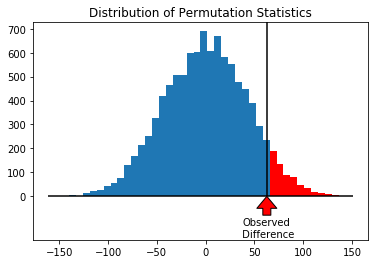

In [7]:
permutation_test_plot(permutation_differences, observed_difference, alternative = 'larger')

In [8]:
permutation_test_p(permutation_differences, observed_difference, alternative = 'larger')

0.0697

This tells us that if there were no difference in the distribution of sleeping times, we would see a differnce in sample means at least as large as what we observed 7.2% of the time. This is not below the 5% threshold, so we will not reject the null hypothesis that there is not difference in the distribution of sleeping times among males and females.

Now, let's repeat this for the grooming dataset.

In [9]:
grooming = pd.read_csv('../data/atus_grooming.csv')
observed_difference = grooming[grooming.sex == 'Female'].minutes_spent_grooming.mean() - grooming[grooming.sex == 'Male'].minutes_spent_grooming.mean()
observed_difference

20.68

In [10]:
num_Female = len(grooming[grooming.sex == 'Female'])
grooming_times = grooming.minutes_spent_grooming.tolist()

In [11]:
permutation_differences = generate_permutations(values = grooming_times,
                                                label_count = num_Female,
                                                statistic = np.mean)

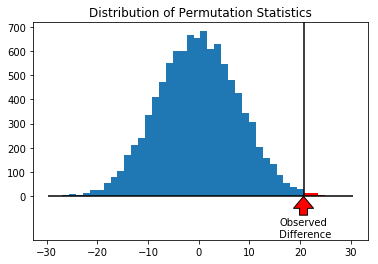

In [12]:
permutation_test_plot(permutation_differences, observed_difference, alternative = 'larger')

In [13]:
permutation_test_p(permutation_differences, observed_difference, alternative = 'larger')

0.0034

In this case, if the null hypothesis were true and there really was no difference in the distribution of time spent grooming for males and females, then we would observe an as extreme or more extreme result only 0.3% of the time. This is below the threshold of 5%, so we will reject the null hypothesis and conclude that there is a difference in the distribution of grooming times for males and females.

## Permutation Test for Proportion

We can also perform permutation tests for the difference in proportions. Here, we randomly shuffle the values and recalculate the difference in observed proportions across groups.

We can use the same functions as above by passing in a list of Booleans (True/False), since computing the mean of a list of Booleans is the same as calculating the proportion of True values. Python treats True as 1 and False as 0.

In [14]:
squirrels = pd.read_csv('../data/2018_Central_Park_Squirrel_Census_-_Squirrel_Data.csv')

In [15]:
squirrels = squirrels[~squirrels['Primary Fur Color'].isna()]

squirrels['Black'] = squirrels['Primary Fur Color'] == 'Black'

In [16]:
observed_difference = np.mean(squirrels[squirrels['Black'] == True]['Runs from']) - np.mean(squirrels[squirrels['Black'] == False]['Runs from'])
observed_difference

0.08799200257544179

So in our data, we say that the proportion on black squirrels that ran away from humans was 8.8% higher than the proportion of non-black squirrels that ran away from humans.

In [17]:
num_black = len(squirrels[squirrels['Black'] == True])
run = squirrels['Runs from'].to_list()

In [18]:
permutation_differences = generate_permutations(values = run, label_count = num_black)

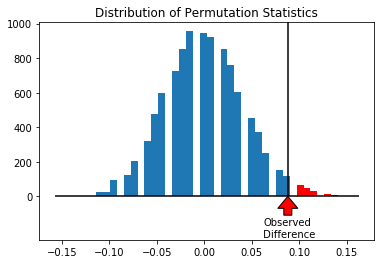

In [19]:
permutation_test_plot(permutation_differences, observed_difference, alternative = 'larger')

In [20]:
permutation_test_p(permutation_differences, observed_difference, alternative = 'larger')

0.0278

Here, we would only see at least as an extreme an observation 2.4% of the time if there was no difference between black squirrels and other squirrels. Therefore, we reject the null hypothesis and conclude that there black squirrels are more likely to run away.

## Permutation Testing of Correlation

Let's see how to conduct a hypothesis test about correlation. We'll step through the example from the slides. Recall that the null and alternative hypotheses were

$$H_0: \text{The correlation between temperature and NOx concentration is 0}$$

$$H_1: \text{There is a negative correlation between temperature and NOx concentration.}$$

Let's read in the data.

In [21]:
air_quality = pd.read_csv('../data/air_quality.csv')

In [22]:
air_quality.head()

,Date,Temperature,NOx
0,22/03/2005,20.2,473.0
1,11/07/2004,29.5,32.0
2,29/05/2004,22.9,61.0
3,28/11/2004,11.2,60.0
4,02/06/2004,21.7,62.0


The scatterplot of the two relevant variables:

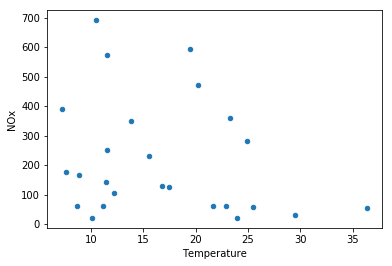

In [23]:
air_quality.plot(kind = 'scatter', x = 'Temperature', y = 'NOx');

The observed correlation.

In [24]:
np.corrcoef(air_quality['Temperature'], air_quality['NOx'])

array([[ 1.        , -0.24157135],
       [-0.24157135,  1.        ]])

In [25]:
observed_correlation = np.corrcoef(air_quality['Temperature'], air_quality['NOx'])[0,1]

To conduct the permutation test, we can first generate the permutations using the generate_permutations_correlation function from nssstats.permutations.

In [26]:
from nssstats.permutation import generate_permutations_correlation

To use this function, you need to pass in the two columns on interest as lists.

In [27]:
permutation_correlations = generate_permutations_correlation(air_quality['Temperature'].tolist(), 
                                                             air_quality['NOx'].tolist())

Now we can get the p-value and plot the permuted correlations.

In [28]:
permutation_test_p(permutation_correlations, observed_correlation, alternative = 'smaller')

0.1247

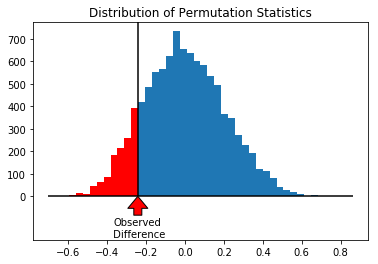

In [29]:
permutation_test_plot(permutation_correlations, observed_correlation, alternative = 'smaller')

You can see from the $p$-value and plot that our observed correlation would not be all that unusual if the null were true. You can expect to see an observed correlation at least as large more than 12% of the time. Thus, we cannot reject the null hypothesis. Our data does not provide enough evidence to conclude that there is a negative correlation between temperature and NOx value.